# Working with OSM data

This notebook introduces three python packeges to work with OpenStreetMap data. First two fetches tiles as image, the third one can fetch administrative boundaries as GeoDataFrame and most importantly get roads as networkX graph!

## smopy

- It seems to be in the early stage of developement, does not much (yet), but does it well
- The documentation is in the code, see [on Github](https://github.com/rossant/smopy)
- BSD-3-clause licenc


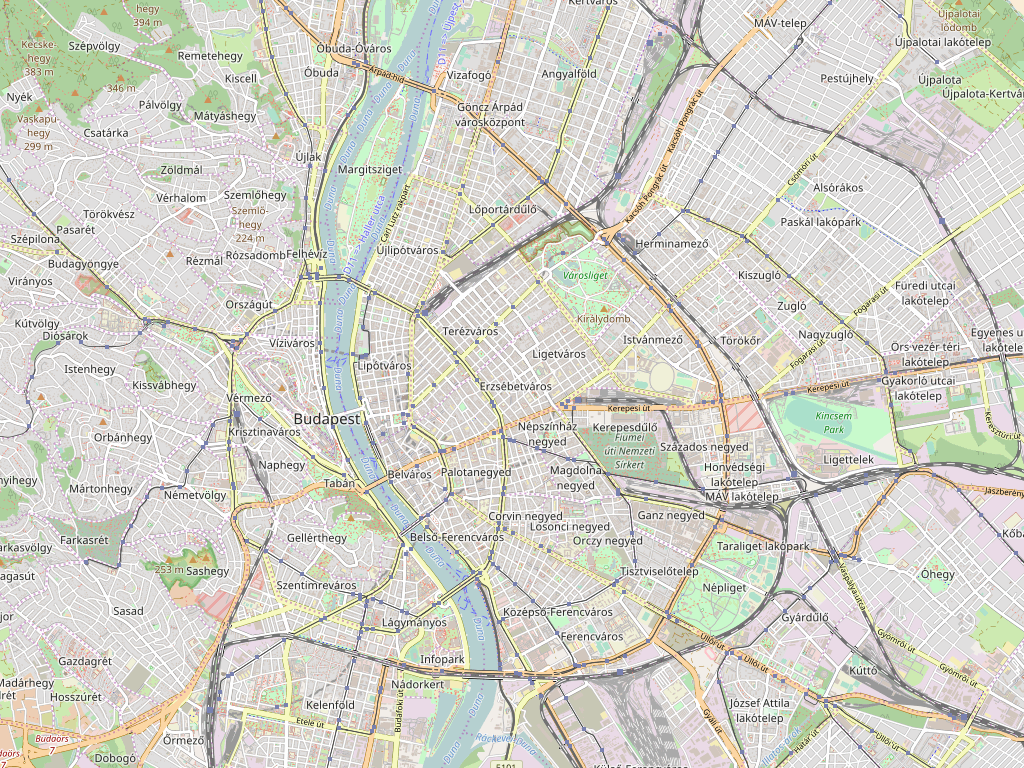

In [1]:
import smopy
map = smopy.Map((47.4672, 19.006, 47.5236, 19.112), z=13)
map.show_ipython()

## GeoTiler

[GeoTiler features:](https://wrobell.dcmod.org/geotiler/intro.html)

> - Very easy map API, which can be used in interactive and non-interactive way with other libraries, i.e. matplotlib, Cairo, Qt, etc.
> - Supported multiple map tiles providers, i.e. OpenStreetMap, Stamen and Blue Marble.
> - Asynchronous and synchronous map tiles downloader.
> - Map tiles caching with Redis and support for custom caching strategies.
> - The library design supports extensibility. Implement custom map tiles providers, tiles downloading or caching strategies within minutes.


- https://wrobell.dcmod.org/geotiler/usage.html
- [GitHub](https://github.com/wrobell/geotiler)


The following example is just a modification of [this](https://wrobell.dcmod.org/geotiler/usage.html#matplotlib-example)

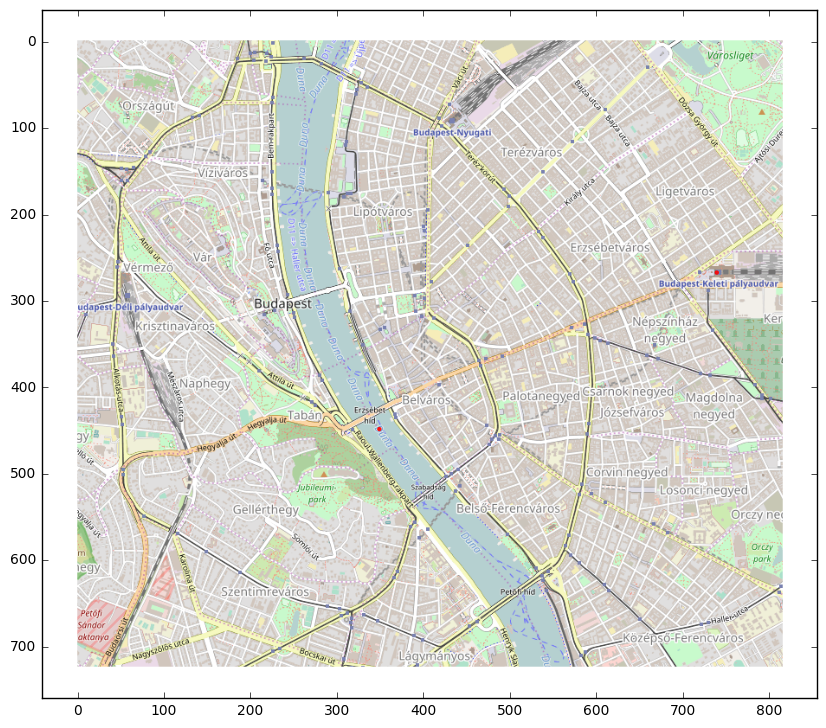

In [11]:
import matplotlib.pyplot as plt

import logging
# logging.basicConfig(level=logging.DEBUG)

import geotiler

bbox = 19.006, 47.4672, 19.112, 47.5236
bbox = 19.02,47.474, 19.09,47.516

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

#
# download background map using OpenStreetMap
#
mm = geotiler.Map(extent=bbox, zoom=14)

img = geotiler.render_map(mm)
ax.imshow(img)

#
# plot custom points
#
x0, y0 = 19.05, 47.49
x1, y1 = 19.0835, 47.5005
points = ((x0, y0), (x1, y1))
x, y = zip(*(mm.rev_geocode(p) for p in points))
ax.scatter(x, y, c='red', edgecolor='none', s=10, alpha=0.9)

plt.show()
#plt.savefig('ex-matplotlib.pdf', bbox_inches='tight')
#plt.close()

### Grayscale labelles map

I needed a map with terrain background and roads (lines) but without labels, so [I added these providers](https://github.com/wrobell/geotiler/pull/10).
I use them according to the following snippet.

Other options for maps without label: https://help.openstreetmap.org/questions/28483/how-to-remove-tags-and-street-names

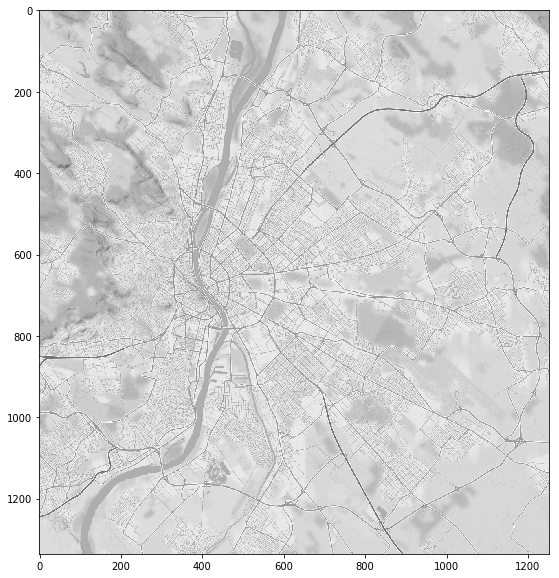

In [8]:
import geotiler
import matplotlib.pyplot as plt

bbox = 18.91, 47.34, 19.34, 47.65

lines = geotiler.Map(extent=bbox, zoom=12, provider="stamen-terrain-lines")
bg = geotiler.Map(extent=bbox, zoom=12, provider="stamen-terrain-background")

background = geotiler.render_map(bg)
foreground = geotiler.render_map(lines)
background.paste(foreground, (0, 0), foreground)

fig_gt = plt.figure(figsize=(12, 10))
ax_gt = plt.subplot(111)

ax_gt.imshow(background.convert('LA'))
plt.show()

## OSMnx

- Geoff Boeing's blog post about OSMnx: http://geoffboeing.com/2016/11/osmnx-python-street-networks/ (the example below is based on 2a)
- [GitHub page](https://github.com/gboeing/osmnx)
- can be cited as: Boeing, G. 2016. “OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks.” Manuscript under review. doi:10.2139/ssrn.2865501
    - [Geoff Boeing's publications](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
    
- it uses [NetworkX](https://networkx.github.io/) to build a graph from the street network

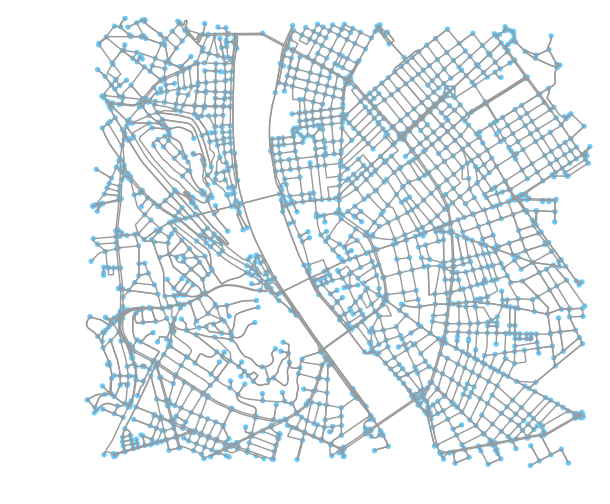

In [16]:
import osmnx as ox
ox.config(log_console=False, use_cache=True) # config logging and caching

G = ox.graph_from_bbox(47.516,47.474,19.09,19.02, network_type='drive') # max Y, min Y; max X, min X
G_projected = ox.project_graph(G)
fix, ax = ox.plot_graph(G_projected) # nodeseize=0 removes the node representing dots

### Plot onto an OSMnx plot

If I want to use the steet map as a "background", it is important not to close or show the map, other sample in [this sample notebook](https://github.com/gboeing/osmnx/blob/master/examples/07-example-plot-network-over-shape.ipynb).

The `project_graph` projects the map (graph) to [UTM](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system), so if I want to plot some points onto the map defined by GPS coordinates (WGS84, EPSG:4326) I have to reproject them as the following:

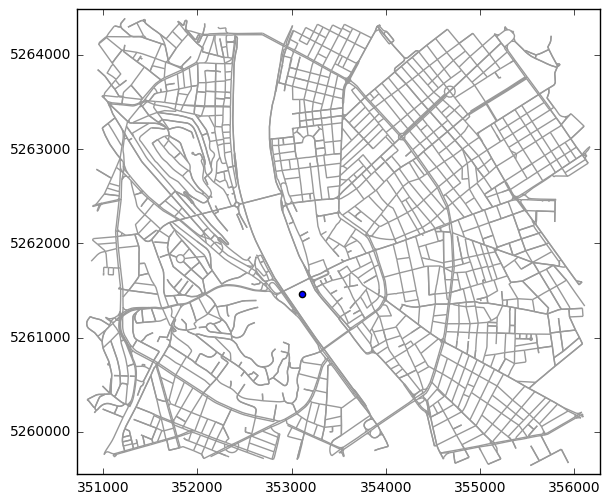

In [15]:
from shapely.geometry import *
import osmnx as ox

G = ox.graph_from_bbox(47.516,47.474,19.09,19.02, network_type='drive')
G_projected = ox.project_graph(G)

# define point, arbitrary polygon or multipolygon can be used from Shapely
g = Point(19.05,47.49)
# reproject it to UTM with OSMnx's builtin function, as the point is just created, does not carries projection, it have to be specified
g_proj, g_crs = ox.projection.project_geometry(g, {'init': 'epsg:4326'})
# get the graph without plotting or closing, (axis is turned on now)
f,a = ox.plot_graph(G_projected,close=False,show=False,node_size=0,axis_off=False)

# by using UTM coordinates it would be something like this
#a.scatter([353020], [5262000], zorder=10)

a.scatter(g_proj.x, g_proj.y, zorder=10) # zorder tells matplotlib which one should be top
plt.show()

## other links

- https://www.researchgate.net/publication/7179558_Centrality_in_Network_of_Urban_Streets/figures?lo=1
- [a blogpost about `geopandas_osm` package, but could not install - 2017-01-21](http://michelleful.github.io/code-blog/2015/04/27/osm-data/)
- [there is also `pandana`, but could not install as well - 2017-01-21](https://github.com/UDST/pandana)

### how to plot a previously created figure

Based on [this](http://stackoverflow.com/a/6917046/4737417), but with corrections

``` python
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(5)
y = np.exp(x)
plt.figure(0)
plt.plot(x, y)

z = np.sin(x)
plt.figure(1)
plt.plot(x, z)

w = np.cos(x)
plt.figure(0) # Here's the part I need
plt.plot(x, w)
```

To get the figure `pl.figure(f1.number)`, from [here](http://stackoverflow.com/a/7987462/4737417)